In [40]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory: current working directory of the notebook
BASE_DIR = Path().resolve()

# Folder where your CSV files are stored
DATA_DIR = BASE_DIR / "data"

# Folder where all figures will be saved
RESULTS_DIR = BASE_DIR / "resultats"
os.makedirs(RESULTS_DIR, exist_ok=True)

print("BASE_DIR    :", BASE_DIR)
print("DATA_DIR    :", DATA_DIR)
print("RESULTS_DIR :", RESULTS_DIR)





BASE_DIR    : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer
DATA_DIR    : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\data
RESULTS_DIR : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats


This cell imports all the Python libraries used in the analysis (NumPy, pandas, Matplotlib, Seaborn) and defines the main folders. BASE_DIR is the working directory of the notebook, DATA_DIR points to the folder where the CSV files are stored, and RESULTS_DIR is the folder where all generated figures will be saved. If resultats/ does not exist, it is created. This cell does not process any data yet; it just prepares the environment.

In [41]:
def plot_comparison_box(df_ankle: pd.DataFrame, df_wrist: pd.DataFrame, title: str):
    combined = pd.concat(
        [
            pd.DataFrame(
                {"location": "ankle",
                 "ENMO": df_ankle["ENMO"],
                 "MAD": df_ankle["MAD"]}
            ),
            pd.DataFrame(
                {"location": "wrist",
                 "ENMO": df_wrist["ENMO"],
                 "MAD": df_wrist["MAD"]}
            ),
        ],
        ignore_index=True,
    )

    print("Unique locations:", combined["location"].unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ankle = blue, wrist = orange
    palette = ["tab:blue", "tab:orange"]

    sns.boxplot(
        ax=axes[0],
        data=combined,
        x="location",
        y="ENMO",
        order=["ankle", "wrist"],
        palette=palette,
    )
    axes[0].set_title(f"ENMO – {title}")

    sns.boxplot(
        ax=axes[1],
        data=combined,
        x="location",
        y="MAD",
        order=["ankle", "wrist"],
        palette=palette,
    )
    axes[1].set_title(f"MAD – {title}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

    out_path = RESULTS_DIR / f"{title}_ankle_vs_wrist.png"
    fig.savefig(out_path, dpi=300)

    plt.show()
    plt.close(fig)

    print(f"Ankle vs wrist figure saved: {out_path}")


This cell generates the comparative boxplots between ankle and wrist for trial 2 only. It defines a list of pairs of filenames (one ankle file and one wrist file for each series), builds the full paths using DATA_DIR, and reads each file with read_accel_file_box. If both files are valid, it computes ENMO and MAD for ankle and wrist with compute_metrics_box, then calls plot_comparison_box to create side-by-side boxplots of ENMO and MAD for that series. Each comparison is saved as an image in the resultats/ folder. This cell does not recompute time-series integrals; it focuses on the distribution of ENMO and MAD for ankle versus wrist in trial 2.


 Comparative ankle vs wrist boxplots

Reading file: ankle_Series1_trial2.csv

Reading file: wrist_Series1_trial2.csv
Unique locations: ['ankle' 'wrist']


C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


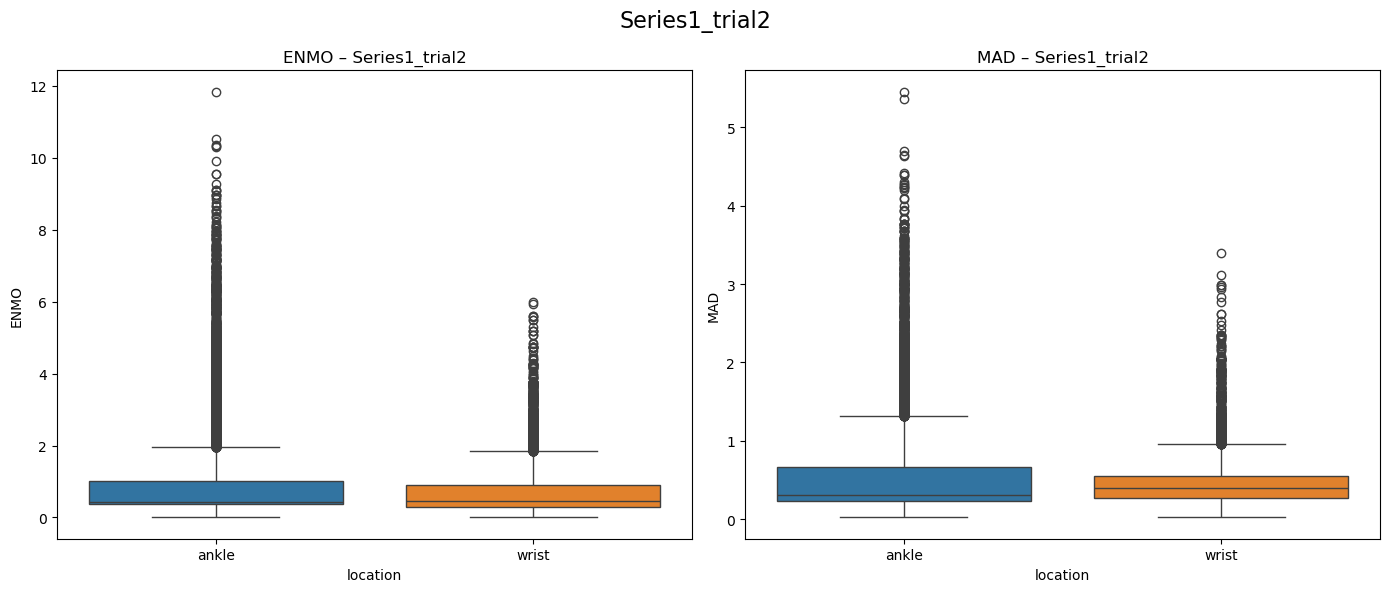

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series1_trial2_ankle_vs_wrist.png
Comparison generated for Series1_trial2
--------------------------------------------

Reading file: ankle_Series2_trial2.csv

Reading file: wrist_Series2_trial2.csv
Unique locations: ['ankle' 'wrist']


C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


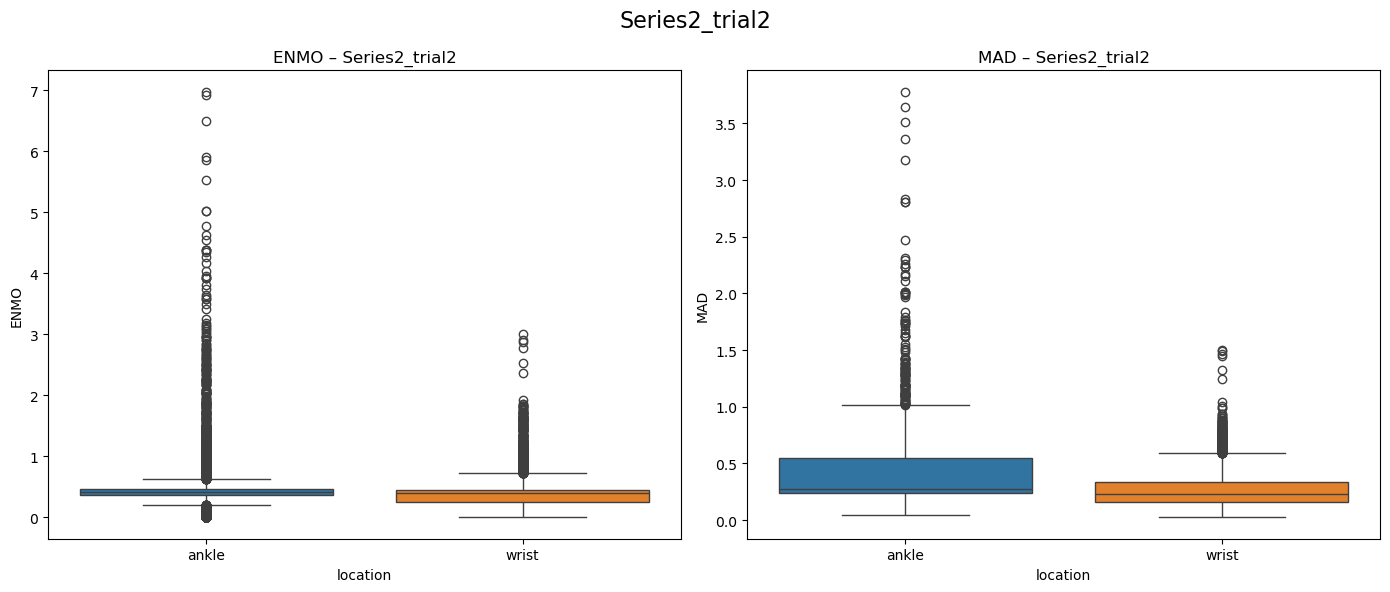

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series2_trial2_ankle_vs_wrist.png
Comparison generated for Series2_trial2
--------------------------------------------

Reading file: ankle_Series3_trial2.csv

Reading file: wrist_Series3_trial2.csv
Unique locations: ['ankle' 'wrist']


C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_17600\3321468827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


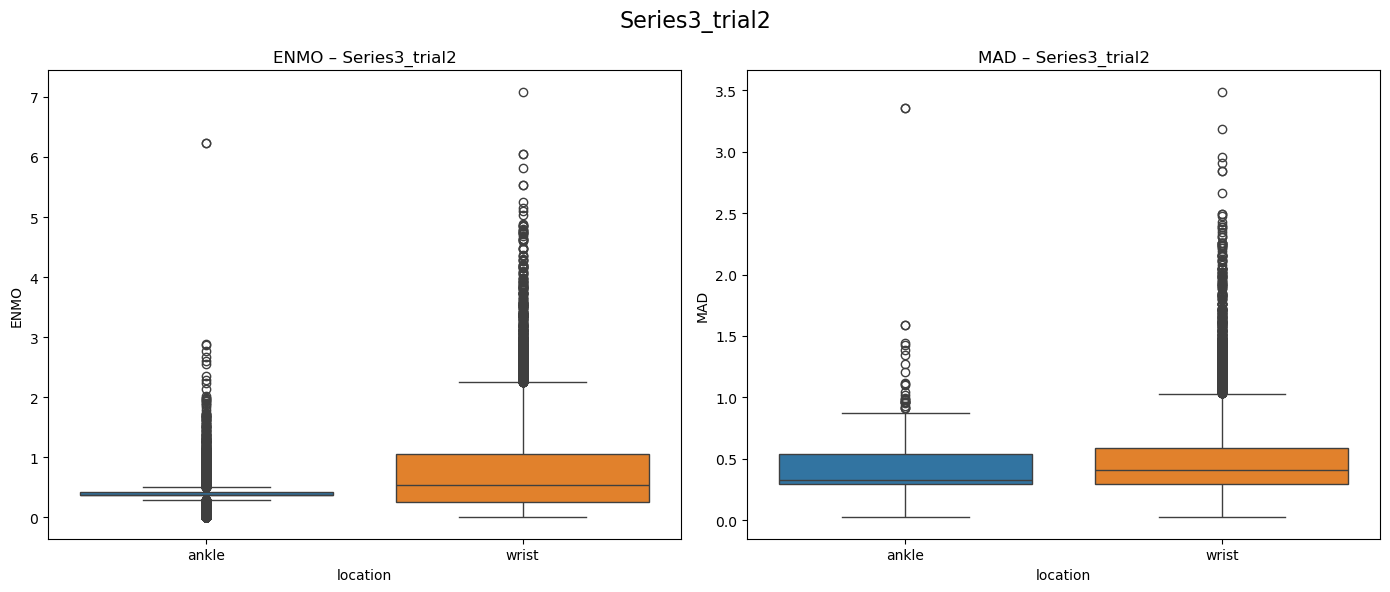

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series3_trial2_ankle_vs_wrist.png
Comparison generated for Series3_trial2
--------------------------------------------

All comparative boxplots have been generated.


In [42]:
print("\n==============================")
print(" Comparative ankle vs wrist boxplots")
print("==============================")

# List of files to compare (must exist in DATA_DIR)
comparisons = [
    ("Series1_trial2", "ankle_Series1_trial2.csv", "wrist_Series1_trial2.csv"),
    ("Series2_trial2", "ankle_Series2_trial2.csv", "wrist_Series2_trial2.csv"),
    ("Series3_trial2", "ankle_Series3_trial2.csv", "wrist_Series3_trial2.csv"),
]

for label, ankle_file, wrist_file in comparisons:
    path_ankle = DATA_DIR / ankle_file
    path_wrist = DATA_DIR / wrist_file

    df_ankle = read_accel_file_box(path_ankle)
    df_wrist = read_accel_file_box(path_wrist)

    if df_ankle is None or df_wrist is None:
        print(f"Not enough data for {label}. Skipping.")
        print("--------------------------------------------")
        continue

    df_ankle = compute_metrics_box(df_ankle)
    df_wrist = compute_metrics_box(df_wrist)

    plot_comparison_box(df_ankle, df_wrist, label)
    print(f"Comparison generated for {label}")
    print("--------------------------------------------")

print("\nAll comparative boxplots have been generated.")
